# Deep Learning

## Aufgabem
1. _Laden der Daten und Splitting in Trainings- und Testdaten (Verhältnis 75:25)._
2. _Überlegen Sie sich eine geeignete Netzwerkarchitektur für die Klassifikationsaufgabe._
3. _Implementieren Sie Ihr Netzwerk in Keras/Tensorflow._
4. _Wahlen Sie eine geeignete Loss-Funktion und einen geeigneten Optimizer. Begründen Sie Ihre
Auswahl in Ihrem Kurzreport._
5. _Evaluieren Sie Ihr ML-System und stellen Sie die Ergebnisse in geeigneter Weise dar. Nutzen Sie
zur Evaluation eine Kreuzvalidierung (3-fold)._
6. _In dem Notebook `transfer_learning.ipynb`_

### Laden der Daten und Splitting in Trainings- und Testdaten (Verhältnis 75:25)
Dieser Schritt ist identisch bei _Merkmalsbasierte Klassifikation_ und _Deep Learning_ und wurde somit in `setup.py` ausgelagert.
Dort wird das Verhältnis durch `split=['train[75%:]', 'test[:25%]']` erstellt.


In [67]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import sys
%matplotlib inline


notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))
from setup import setup_dataset

keras.utils.set_random_seed(0)

verification_image_dir = '../dataset/verification'
model_folder = 'models/'
model_filename = 'dog_classifier.keras'
weights_filename = 'model.weights.h5'

## Hyperparameter definieren

In [68]:
num_classes = 5
batch_size = 33
epochs = 20
learning_rate = 0.001
resize_size = (256, 256)
indices = [0, 2, 77, 84, 55]

## Laden der Datensets

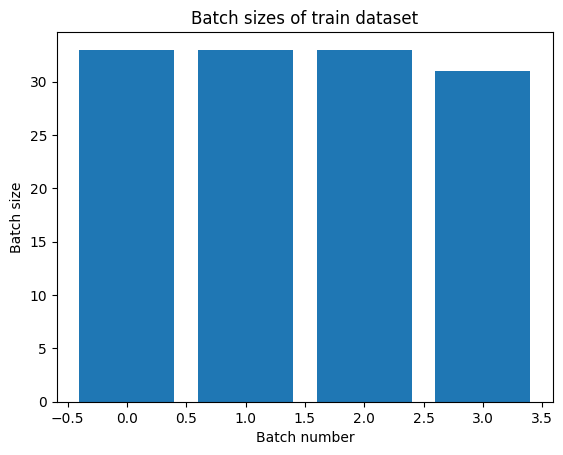

Finished loading data


In [69]:
train_dataset, test_dataset, metadata = setup_dataset('../dataset', labels=indices)

table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(indices, dtype=tf.int64),
        values=tf.constant(list(range(num_classes)),  dtype=tf.int64),
    ),
    default_value= tf.constant(0,  dtype=tf.int64)
)

def preprocess(img, label):
    img = tf.image.resize(img, resize_size)
    img = img / 255.0  # Normalisierung
    label = table.lookup(label)
    return img, tf.one_hot(label, num_classes)  # One-Hot-Encoding der Labels

train_dataset = (
    train_dataset
        .map(preprocess)
        .shuffle(1000)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
        .map(preprocess)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
)

def plot_batch_sizes(ds):
    batch_sizes = [np.array(batch[1]).shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.title("Batch sizes of train dataset")
    plt.xlabel("Batch number")
    plt.ylabel("Batch size")
    plt.show()

plot_batch_sizes(train_dataset)

y = np.concatenate([y for x, y in test_dataset], axis=0)
print("Finished loading data")

# Model erstellen

In [70]:
from kerastuner.tuners import BayesianOptimization

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*resize_size, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
""" def build_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(*resize_size, 3)
    ))
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    if hp.Boolean('dropout_1'):
        model.add(keras.layers.Dropout(rate=hp.Float('dropout_1_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    if hp.Boolean('dropout_2'):
        model.add(keras.layers.Dropout(rate=hp.Float('dropout_2_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='bayesian_opt',
    project_name='dog_classifier'
)

tuner.search(train_dataset, epochs=epochs, validation_data=test_dataset)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0] """

" def build_model(hp):\n    model = keras.models.Sequential()\n    model.add(keras.layers.Conv2D(\n        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),\n        kernel_size=(3, 3),\n        activation='relu',\n        input_shape=(*resize_size, 3)\n    ))\n    model.add(keras.layers.Conv2D(\n        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=32),\n        kernel_size=(3, 3),\n        activation='relu'\n    ))\n    if hp.Boolean('dropout_1'):\n        model.add(keras.layers.Dropout(rate=hp.Float('dropout_1_rate', min_value=0.2, max_value=0.5, step=0.1)))\n    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))\n    model.add(keras.layers.Conv2D(\n        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=32),\n        kernel_size=(3, 3),\n        activation='relu'\n    ))\n    if hp.Boolean('dropout_2'):\n        model.add(keras.layers.Dropout(rate=hp.Float('dropout_2_rate', min_value=0.2, max_value=0.5, step=0.1)))\n   

## Training des Models

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2115 - loss: 38.6740 - val_accuracy: 0.2021 - val_loss: 9.3262 - learning_rate: 0.0010
Epoch 2/20


2024-12-12 16:14:16.851410: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:16.851437: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4366 - loss: 48.8089

2024-12-12 16:14:17.367398: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:17.367423: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.4370 - loss: 47.4965 - val_accuracy: 0.1170 - val_loss: 8.9242 - learning_rate: 0.0010
Epoch 3/20


2024-12-12 16:14:17.595822: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:17.595859: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6350 - loss: 23.1083 - val_accuracy: 0.2553 - val_loss: 12.5211 - learning_rate: 0.0010
Epoch 4/20


2024-12-12 16:14:18.320629: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:18.320682: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7072 - loss: 17.4145

2024-12-12 16:14:18.819462: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:18.819488: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7073 - loss: 16.9531 - val_accuracy: 0.3085 - val_loss: 8.8600 - learning_rate: 0.0010
Epoch 5/20


2024-12-12 16:14:19.047961: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:19.048000: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7738 - loss: 9.0480

2024-12-12 16:14:19.543435: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:19.543471: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7744 - loss: 9.0441 - val_accuracy: 0.3298 - val_loss: 13.1245 - learning_rate: 0.0010
Epoch 6/20


2024-12-12 16:14:19.771156: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:19.771190: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.8250 - loss: 6.5920 - val_accuracy: 0.4574 - val_loss: 16.3116 - learning_rate: 0.0010
Epoch 7/20


2024-12-12 16:14:20.507776: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:20.507800: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7778 - loss: 8.3677

2024-12-12 16:14:20.774867: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25952916 bytes after encountering the first element of size 25952916 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7929 - loss: 7.8369
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000474974512e-06.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8021 - loss: 7.5184 - val_accuracy: 0.4894 - val_loss: 18.2052 - learning_rate: 0.0010
Epoch 8/20


2024-12-12 16:14:21.252469: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:21.252509: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9063 - loss: 2.6926 - val_accuracy: 0.4681 - val_loss: 26.1816 - learning_rate: 1.0000e-06
Epoch 9/20


2024-12-12 16:14:21.987205: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:21.987231: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.8779 - loss: 5.6284 - val_accuracy: 0.4681 - val_loss: 34.7020 - learning_rate: 1.0000e-06
Epoch 10/20


2024-12-12 16:14:22.713381: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:22.713454: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.8730 - loss: 7.2049 - val_accuracy: 0.4468 - val_loss: 42.1031 - learning_rate: 1.0000e-06
Epoch 11/20


2024-12-12 16:14:23.458076: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:23.458104: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9055 - loss: 2.8932 - val_accuracy: 0.4255 - val_loss: 48.7773 - learning_rate: 1.0000e-06
Epoch 12/20


2024-12-12 16:14:24.181971: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:24.181995: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.8862 - loss: 2.0373 - val_accuracy: 0.4255 - val_loss: 54.9355 - learning_rate: 1.0000e-06
Epoch 13/20


2024-12-12 16:14:24.925767: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:24.925797: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.8791 - loss: 2.2799 - val_accuracy: 0.4255 - val_loss: 60.4418 - learning_rate: 1.0000e-06
Epoch 14/20


2024-12-12 16:14:25.703064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:25.703207: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.8741 - loss: 5.1271 - val_accuracy: 0.4255 - val_loss: 65.2911 - learning_rate: 1.0000e-06
Epoch 15/20


2024-12-12 16:14:26.488052: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:26.488079: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9024 - loss: 2.0363

2024-12-12 16:14:26.767178: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25952916 bytes after encountering the first element of size 25952916 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.8953 - loss: 2.0961 - val_accuracy: 0.4255 - val_loss: 69.5844 - learning_rate: 1.0000e-06
Epoch 16/20


2024-12-12 16:14:27.245444: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:27.245492: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9444 - loss: 2.2857

2024-12-12 16:14:27.598827: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25952916 bytes after encountering the first element of size 25952916 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9359 - loss: 2.3119 - val_accuracy: 0.4043 - val_loss: 73.4905 - learning_rate: 1.0000e-06
Epoch 17/20


2024-12-12 16:14:28.067586: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:28.067625: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8955 - loss: 2.6441

2024-12-12 16:14:28.587495: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:28.587522: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.8964 - loss: 2.4891 - val_accuracy: 0.3936 - val_loss: 77.0144 - learning_rate: 1.0000e-06
Epoch 18/20


2024-12-12 16:14:28.819761: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:28.819860: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8805 - loss: 4.9391

2024-12-12 16:14:29.231132: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25952916 bytes after encountering the first element of size 25952916 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.8852 - loss: 4.5230 - val_accuracy: 0.3936 - val_loss: 80.1656 - learning_rate: 1.0000e-06
Epoch 19/20


2024-12-12 16:14:29.698177: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:29.698213: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9069 - loss: 3.1930

2024-12-12 16:14:30.236196: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:30.236234: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9086 - loss: 3.1470 - val_accuracy: 0.3936 - val_loss: 82.9212 - learning_rate: 1.0000e-06
Epoch 20/20


2024-12-12 16:14:30.465124: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:30.465153: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8822 - loss: 4.4419

2024-12-12 16:14:30.988876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.8842 - loss: 4.2829 - val_accuracy: 0.3936 - val_loss: 85.3569 - learning_rate: 1.0000e-06


2024-12-12 16:14:31.216856: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4266677454130355594
2024-12-12 16:14:31.216893: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17662422034860115762


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,759,761 (338.59 MB)

 Trainable params: 29,586,437 (112.86 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 59,172,876 (225.73 MB)

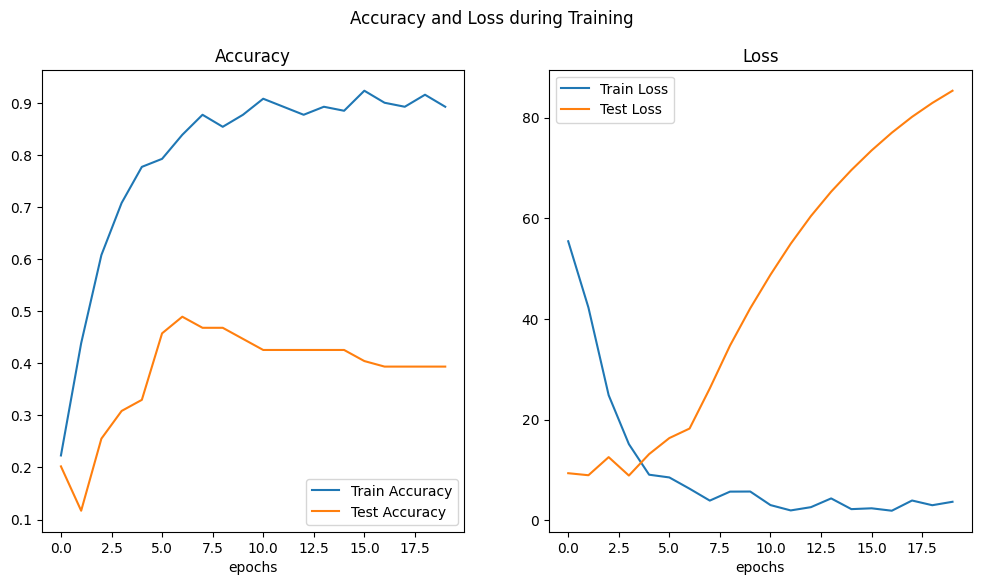

In [71]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.001,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[reduce_lr],
    verbose=1
)

model.save_weights(os.path.join(model_folder, weights_filename))
model.save(os.path.join(model_folder, model_filename))

model.summary()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))
fig.suptitle('Accuracy and Loss during Training')

# Plot Accuracy
ax1.set_title("Accuracy")
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Test Accuracy')
ax1.set(xlabel="epochs")
ax1.legend()

# Plot Loss
ax2.set_title("Loss")
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Test Loss')
ax2.set(xlabel="epochs")
ax2.legend()

plt.show()

# Performancetest des Modells

In [72]:
model = keras.models.load_model(os.path.join(model_folder, model_filename))
print("Model loaded successfully!")

# Step 2: Define Class Labels
# Ensure these match the class labels used during training
class_labels = {
    0: "Chihuahua",
    1: "Maltese Dog",
    2: "Komondor",
    3: "German Shepherd",
    4: "African Hunting Dog"
}
print("Class labels:", class_labels)

# Step 3: Define Image Preprocessing Function
def preprocess_image(img):
    img_array = tf.image.resize(img, resize_size)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Step 4: Predict Function
def predict_image(img):
    preprocessed_image = preprocess_image(img)
    predictions = model.predict(preprocessed_image)
    predicted_class = np.argmax(predictions, axis=-1)[0]
    predicted_label = class_labels[predicted_class]

    # Display the image with its prediction
    img = keras.preprocessing.image.load_img(img)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()
    print(f"Predicted Label: {predicted_label}")

for img in train_dataset:
    print(f"Testing image: {img}")
    predict_image(img)


Model loaded successfully!
Class labels: {0: 'Chihuahua', 1: 'Maltese Dog', 2: 'Komondor', 3: 'German Shepherd', 4: 'African Hunting Dog'}
Testing image: (<tf.Tensor: shape=(33, 256, 256, 3), dtype=float32, numpy=
array([[[[0.16206037, 0.2444133 , 0.12102176],
         [0.2108216 , 0.28572303, 0.15905792],
         [0.2515871 , 0.32665944, 0.19948162],
         ...,
         [0.06834915, 0.20909837, 0.6489719 ],
         [0.07432801, 0.20360191, 0.5709043 ],
         [0.06896548, 0.19655433, 0.5554315 ]],

        [[0.1615554 , 0.24117395, 0.10368724],
         [0.17215995, 0.24171112, 0.10375306],
         [0.22076668, 0.29054046, 0.15191458],
         ...,
         [0.14684197, 0.27693033, 0.57623327],
         [0.14047487, 0.25670034, 0.4956449 ],
         [0.10564797, 0.21901347, 0.4507077 ]],

        [[0.15462449, 0.22065543, 0.07947896],
         [0.16651851, 0.2358353 , 0.08690508],
         [0.22406311, 0.28617248, 0.139803  ],
         ...,
         [0.04697732, 0.14130841, 0

InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} Shapes of all inputs must match: values[0].shape = [33,256,256,3] != values[1].shape = [33,5] [Op:Pack] name: images